In [ ]:
"""
Posterior sampling for Gaussian Mixture Model with CRP prior (DPGMM) using Gibbs sampler
Reference: https://pdfs.semanticscholar.org/9ece/0336316d78837076ef048f3d07e953e38072.pdf
"""
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


# Generate data
X1 = np.random.multivariate_normal([5, 5], np.diag([0.5, 0.5]), size=20)
X2 = np.random.multivariate_normal([8, 8], np.diag([0.5, 0.5]), size=20)
X3 = np.random.multivariate_normal([20, 20], np.diag([0.5, 0.5]), size=10)
X = np.vstack([X1, X2, X3])

N, D = X.shape

# GMM params
mus = []  # List of 2x1 vector (mean vector of each gaussian)
sigma = np.eye(D)
prec = np.linalg.inv(sigma)  # Fixed precision matrix for all Gaussians
zs = np.zeros([N], dtype=int)  # Assignments
C = []  # Cluster: binary matrix of K x M
Ns = []  # Count of each cluster

# CRP prior
alpha = 100

# Base distribution prior: N(mu0, prec0)
mu0 = np.ones(D)
sigma0 = np.eye(D)
prec0 = np.linalg.inv(np.eye(D))
G0 = st.multivariate_normal(mean=mu0, cov=np.eye(D))


# Initialize with ONE cluster
C.append(np.ones(N, dtype=int))
zs[:] = 0
Ns.append(N)
mus.append(G0.rvs())
K = 1

mvn = st.multivariate_normal


# Gibbs sampler
for it in range(20):
    # --------------------------------------------------------
    # Sample from full conditional of assignment from CRP prior
    # z ~ GEM(alpha)
    # --------------------------------------------------------

    # For each data point, draw the cluster assignment
    for i in range(N):
        # Remove assignment from cluster
        # ------------------------------

        zi = zs[i]
        C[zi][i] = 0
        Ns[zi] -= 1

        # If empty, remove cluster
        if Ns[zi] == 0:
            # Fix indices
            zs[zs > zi] -= 1

            # Delete cluster
            del C[zi]
            del Ns[zi]
            del mus[zi]

            # Decrement cluster count
            K -= 1

        # Draw new assignment zi weighted by CRP prior
        # --------------------------------------------

        probs = np.zeros(K+1)
        zs_minus_i = zs[np.arange(len(zs)) != i]

        # Probs of joining existing cluster
        for k in range(K):
            nk_minus = zs_minus_i[zs_minus_i == k].shape[0]
            crp = nk_minus / (N + alpha - 1)
            probs[k] = crp * mvn.pdf(X[i], mus[k], sigma)

        # Prob of creating new cluster
        crp = alpha / (N + alpha - 1)
        lik = mvn.pdf(X[i], mu0, sigma0+sigma)  # marginal dist. of x
        probs[K] = crp*lik

        # Normalize
        probs /= np.sum(probs)

        # Draw new assignment for i
        z = np.random.multinomial(n=1, pvals=probs).argmax()

        # Update assignment trackers
        if z == K:
            C.append(np.zeros(N, dtype=int))
            Ns.append(0)
            mus.append(G0.rvs())
            K += 1

        zs[i] = z
        C[z][i] = 1
        Ns[z] += 1

    # -------------------------------------------------
    # Sample from full conditional of cluster parameter
    # -------------------------------------------------

    # Assume fixed covariance => posterior is Normal
    # mu ~ N(mu, sigma)
    for k in range(K):
        Xk = X[zs == k]
        Ns[k] = Xk.shape[0]

        # Covariance of posterior
        lambda_post = prec0 + Ns[k]*prec
        cov_post = np.linalg.inv(lambda_post)

        # Mean of posterior
        left = cov_post
        right = prec0 @ mu0 + Ns[k]*prec @ np.mean(Xk, axis=0)
        mus_post = left @ right

        # Draw new mean sample from posterior
        mus[k] = mvn.rvs(mus_post, cov_post)


# Even though we only initialize with one cluster, the result should be:
#
# Expected output:
# ----------------
# 20 data in cluster-0, mean: [ 5  5 ]
# 20 data in cluster-1, mean: [ 8  8 ]
# 10 data in cluster-2, mean: [ 20  20 ]
#
# Note: cluster label is exchangeable
for k in range(K):
    print('{} data in cluster-{}, mean: {}'.format(Ns[k], k, mus[k]))


In [1]:
# Generalized t-Distribution log PDF
t_logpdf <- function(x, mu, v, df)
{
  g <- lgamma(0.5 * df + 0.5) - lgamma(0.5 * df) - log(sqrt(df * pi * v))
  return(g - 0.5 * (df + 1) * log(1 + (1 / df) * ((x - mu)^2) / v))
}

# Normalize a log probability vector without numerical underflow/overflow
normalize_logprob <- function(log.prob)
{
  # Compute the log of the normalizing constant.
  g <- log(sum(exp(log.prob - max(log.prob)))) + max(log.prob)
  
  # Find probabilities by exponentiating normalized log probabilities.
  return(exp(log.prob - g))
}

# Calculate the log likelihood for the Gaussian DP mixture model
# Mean and variance parameters marginalized under normal-gamma prior
# This corresponds to a generalized Student's t-distribution
# NB: some constant terms are ignored
dpmm_loglik <- function(xn, x, tau0, beta0, mu0, kappa0)
{
  N <- length(x)
  kappaN <- kappa0 + N
  tauN <- tau0 + N / 2
  
  if (N > 0)
  {
    # If there previous observations, use the current posterior.
    xm <- mean(x)
    betaN <- beta0 + 0.5 * sum((x - xm)^2) + (kappa0 * N *(xm - mu0)^2) / (2 * kappaN)
    muN <- (kappa0 * mu0 + N * xm) / kappaN
  }
  else
  {
    # If there are no previous observations, revert to the prior.
    betaN <- beta0
    muN <- mu0
  }
  
  return(t_logpdf(xn, muN, betaN * (kappaN + 1) / (tauN * kappaN), 2 * kappaN))
}

# Gibbs sampling for the Gaussian Dirichlet process mixture model
#
# Inputs:
#  x - data (vector of length N)
#  alpha - DP concentration parameter
#  tau0 - normal-gamma prior shape
#  beta0 - normal-gamma prior rate (inverse scale)
#  kappa0 - normal-gamma prior precision scaling parameter
#  nIter - number of Gibbs iterations
#
# Outputs:
#  C, a N x nIter matrix of cluster assignments
dpmm_gibbs <- function(x, alpha, tau0, beta0, mu0, kappa0, nIter)
{
  N <- length(x)
  logpost <- rep(1, 1, nIter)
  p <- rep(1, 1, N)
  C <- matrix(data = NA, nrow = N, ncol = nIter)
  c <-rep(1, 1, N)
  m <- rep(0, 1, N)
  m[1] <- N
  logprior <- rep(1, 1, N)
  loglik <- rep(1, 1, N)
  ix <- 1:N
  
  for (i in 1:nIter)
  {
    print(paste("Iteration", i))
    
    for (n in 1:N)
    {
      #all customers except n
      cn <- c[1:N!=n]
      
      #count cluster assignments
      for (k in 1:N)
      {
        m[k] <- sum(cn == k)
      }
      
      if (all(m > 0))
      {
        #active dishes
        K.active <- ix[m > 0]
      }
      else
      {
        #active dishes + 1 new dish
        K.active <- c(ix[m > 0], min(ix[m == 0]))
      }
      for (k in K.active)
      {
        if (m[k] > 0)
        {
          #prior for old dish
          logprior[k] <- log(m[k])
        }
        else
        {
          #prior for new dish
          logprior[k] <- log(alpha)
        }
        #calculate log likelihood
        loglik[k] <- dpmm_loglik(x[n], x[c==k], tau0, beta0, mu0, kappa0)
      }
      
      #posterior
      post <- normalize_logprob(logprior[K.active] + loglik[K.active])
      
      #update cluster assignment
      c[n] <- sample(K.active, 1, rep = TRUE, prob = post)
    }
    
    C[,i] = c
  }
  C
}

In [3]:
x <- c(rnorm(100, 100, 8), rnorm(50, 200, 25), rnorm(50, 25, 1))
labels <- c(rep("A", 100), rep("B", 50), rep("C", 50))
df <- data.frame(X = x, Label = labels)

In [13]:
library(ggplot2)

nIter <- 100
results <- dpmm_gibbs(x, 0.01, 0.1, 0.1, 0, 0.1, nIter)
results[, nIter]

[1] "Iteration 1"
[1] "Iteration 2"
[1] "Iteration 3"
[1] "Iteration 4"
[1] "Iteration 5"
[1] "Iteration 6"
[1] "Iteration 7"
[1] "Iteration 8"
[1] "Iteration 9"
[1] "Iteration 10"
[1] "Iteration 11"
[1] "Iteration 12"
[1] "Iteration 13"
[1] "Iteration 14"
[1] "Iteration 15"
[1] "Iteration 16"
[1] "Iteration 17"
[1] "Iteration 18"
[1] "Iteration 19"
[1] "Iteration 20"
[1] "Iteration 21"
[1] "Iteration 22"
[1] "Iteration 23"
[1] "Iteration 24"
[1] "Iteration 25"
[1] "Iteration 26"
[1] "Iteration 27"
[1] "Iteration 28"
[1] "Iteration 29"
[1] "Iteration 30"
[1] "Iteration 31"
[1] "Iteration 32"
[1] "Iteration 33"
[1] "Iteration 34"
[1] "Iteration 35"
[1] "Iteration 36"
[1] "Iteration 37"
[1] "Iteration 38"
[1] "Iteration 39"
[1] "Iteration 40"
[1] "Iteration 41"
[1] "Iteration 42"
[1] "Iteration 43"
[1] "Iteration 44"
[1] "Iteration 45"
[1] "Iteration 46"
[1] "Iteration 47"
[1] "Iteration 48"
[1] "Iteration 49"
[1] "Iteration 50"
[1] "Iteration 51"
[1] "Iteration 52"
[1] "Iteration 53"
[1

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [14]:
results

1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1


ERROR while rich displaying an object: Error in factor(results[, nIter]): object 'results' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(capture.output(print(obj)), collapse = "\n")
10. capture.output(print(obj))
11. evalVis(expr)
12. withVisible(eval(expr, pf))
13. eval(expr, pf)
14. eval(expr, pf)
15. print(obj)
16. print.ggplot(obj)
17. ggplot_build(x)
18. ggplot_build.ggplot(x)


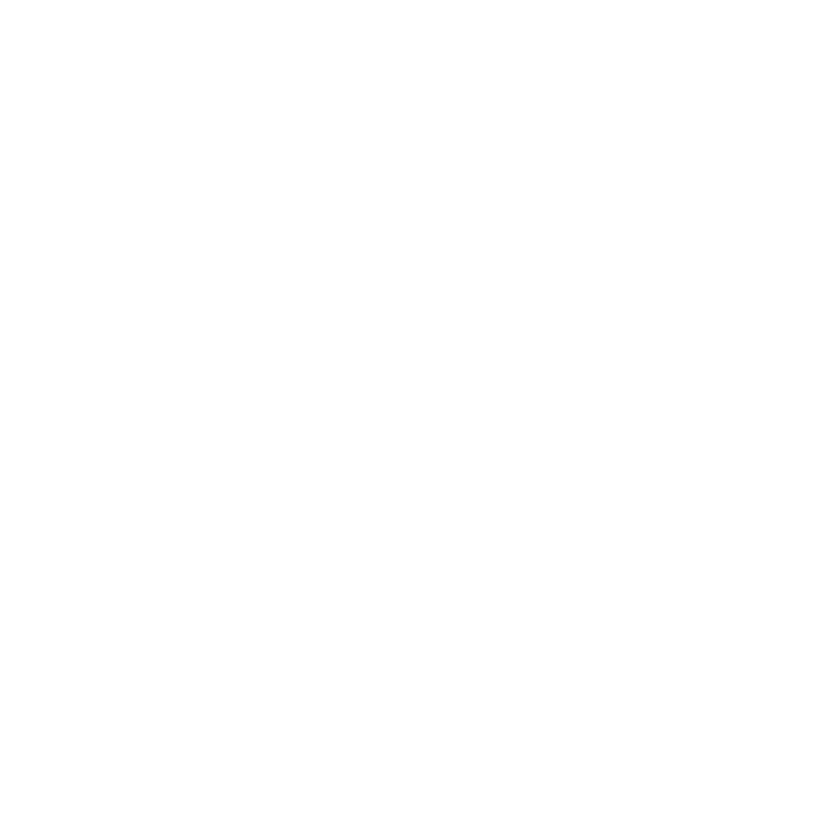

In [9]:
ggplot(df, aes(x = X, fill = factor(results[, nIter]))) +
  geom_histogram(binwidth = 3) 